In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

<Axes: >

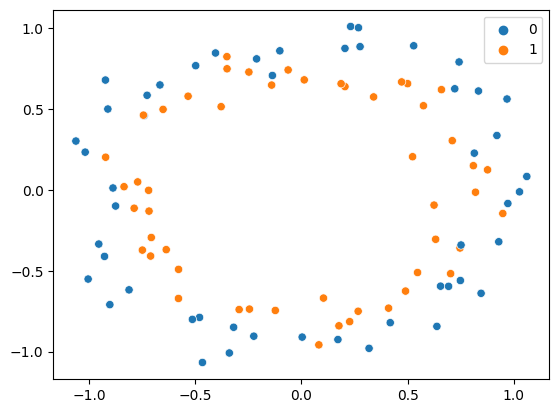

In [ ]:
sb.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class ActivationTracker(Callback):
  def __init__(self, model, x_train):
    super(ActivationTracker, self).__init__()
    self.model = model
    self.x_train = x_train
    self.activations_arr = []
  def on_epoch_end(self, epoch, logs=None):
    L = len(self.model.layers)
    for l in range(L):
      # Retrieve the layer output using Keras backend function
      get_layer_output = tf.keras.backend.function([self.model.input], [self.model.layers[l].output])

      # Get the layer output for the current batch
      layer_output = get_layer_output([self.x_train])[0]
      self.activations_arr.append(layer_output)


# Custom Callback to track gradients
class GradientTracker(Callback):
  def __init__(self, model, x_train, y_train):
    super(GradientTracker, self).__init__()
    self.model = model
    self.gradient_arr = []
    self.x_train = x_train
    self.y_train = y_train
    self.batch_arr = []
    self.predictions_arr = []

  def on_batch_begin(self, batch, logs=None):
    self.batch_arr.append(batch)

    if self.model._fit_epoch == 0 or self.model._fit_epoch == 99:
      # Get gradients for a batch of data
      train_vars = self.model.layers[0].trainable_variables

      batch_size = 32

      # Get gradients for a batch of data
      inputs = self.x_train[batch * batch_size:(batch + 1) * batch_size]
      targets = self.y_train[batch * batch_size:(batch + 1) * batch_size]

      with tf.GradientTape(persistent=True) as tape:
          predictions = self.model(inputs)
          loss = self.model.compiled_loss(targets, predictions)
      gradients = tape.gradient(loss, train_vars)

      self.gradient_arr.append(gradients)

  def on_batch_end(self, batch, logs=None):
    batch_size = 32
    inputs = self.x_train[batch * batch_size:(batch + 1) * batch_size]
    self.predictions_arr.append(self.model(inputs))

In [ ]:
# Reshape using NumPy
reshaped_y = y.reshape(-1, 1)

# Convert NumPy array to TensorFlow EagerTensor
y_tensor = tf.constant(reshaped_y)

# Test 0 initialization

## ReLU activated layer

In [ ]:
model = Sequential()

layer_1_weights = np.zeros((2, 32))
layer_1_biases = np.zeros((32, ))

layer_2_weights = np.zeros((32, 1))
layer_2_biases = np.zeros((1, ))

model.add(Dense(units=32, activation='relu', weights=[layer_1_weights, layer_1_biases], input_shape=(2,)))
model.add(Dense(1, activation='sigmoid', weights=[layer_2_weights, layer_2_biases]))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 32)                96        
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def print_model_layers(model_):
  # weights per layer
  for i in range(len(model_.layers)):
    print(f"For layer {i}:\nWeights = {model_.layers[i].weights[0].numpy()}\n\nBiases = {model_.layers[i].weights[1].numpy()}\n")

In [ ]:
grad_callback = GradientTracker(model, X, y_tensor)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y_tensor, batch_size=32, validation_split=0.2, epochs=100, verbose=0, callbacks=[grad_callback])

In [ ]:
print(len(grad_callback.batch_arr))

300


Because 3 batches of size 32 or small covering entire training set , and 100 epochs.

In [ ]:
print(grad_callback.gradient_arr[0])

[<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>, <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>, <tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


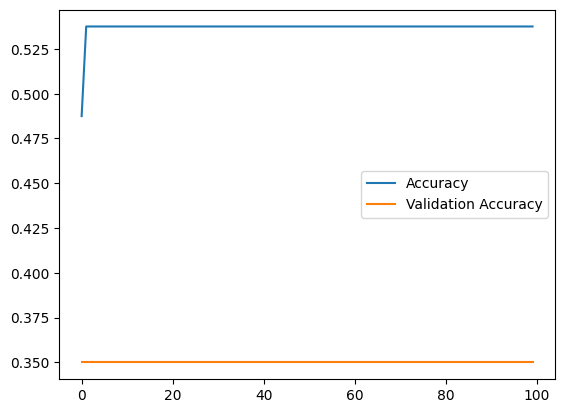

In [ ]:
print(history.history.keys())

plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print_model_layers(model)

For layer 0:
Weights = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]

Biases = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

For layer 1:
Weights = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Biases = [0.08627714]



## Tanh layer

In [ ]:
model = Sequential()

model.add(Dense(units=32, activation='tanh', weights=[np.zeros((2, 32)), np.zeros((32, ))], input_shape=(2,)))
model.add(Dense(units=16, activation='tanh', weights=[np.zeros((32, 16)), np.zeros((16, ))]))
model.add(Dense(units=1, activation='sigmoid', weights=[np.zeros((16, 1)), np.zeros((1, ))]))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 32)                96        
                                                                 
 dense_41 (Dense)            (None, 16)                528       
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
grad_callback_2 = GradientTracker(model, X, y_tensor)

In [ ]:
model.compile(optimizer=SGD(learning_rate = 0.01, momentum=0.0, nesterov=False), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y_tensor, batch_size=32, validation_split=0.2, epochs=100, verbose=0, callbacks=[grad_callback_2])

AttributeError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


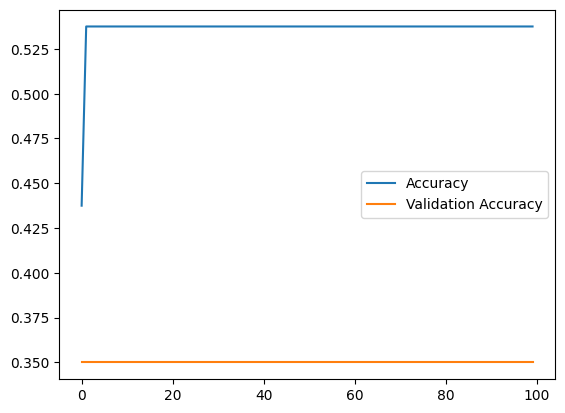

In [ ]:
print(history.history.keys())

plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print(grad_callback_2.gradient_arr[99][0].numpy())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
print_model_layers(model)

For layer 0:
Weights = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]

Biases = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

For layer 1:
Weights = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
import tensorflow as tf

x = tf.constant(0.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.math.tanh(x)

gradient = tape.gradient(y, x)

print(f"Gradient at x=0: {gradient.numpy()}")


Gradient at x=0: 1.0


In [ ]:
print(grad_callback_2.predictions_arr[99])

tf.Tensor(
[[0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]
 [0.5077818]], shape=(32, 1), dtype=float32)


The input to each layer is 0 (since tanh(x=0) = 0), hence the backpropagation gradient matrix has an input matrix to this layer as one of the product components, which makes the entire product = 0.

Take the case of the last sigmoid layer.
1. It gets (16,1) 0's from the previous tanh layer.
2. $\frac{\partial \mathcal{L}}{\partial w^3_1} = -2(y - 0.5)0.5\times 0.5\times x^3_1$ , $x^3_1 = 0$ (third layer first neuron input)
3. Hence, the weight matrix of this last layer remains 0.

Keep in mind that we eventually send this to the previous layer in one backprop. $\Rightarrow$ This is what makes the **gradient matrix of weights of previous layers** also a **null matrix**.

# Constant number initialization

## ReLU activated layer

In [ ]:
model = Sequential()

model.add(Dense(units=32, activation='relu', weights=[np.ones((2, 32))*0.25, np.ones((32, ))*0.25], input_shape=(2,)))
model.add(Dense(units=16, activation='relu', weights=[np.ones((32, 16))*0.75, np.ones((16,))*0.75]))
model.add(Dense(1, activation='sigmoid', weights=[np.ones((16, 1))*0.5, np.ones((1, ))*0.5]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                96        
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def print_model_layers(model_):
  # weights per layer
  for i in range(len(model_.layers)):
    print(f"For layer {i}:\nWeights = {model_.layers[i].weights[0].numpy()}\n\nBiases = {model_.layers[i].weights[1].numpy()}\n")

In [ ]:
print_model_layers(model)

For layer 0:
Weights = [[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25]]

Biases = [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25]

For layer 1:
Weights = [[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [0.75 0.75 0.75 0.

In [ ]:
grad_callback = GradientTracker(model, X, y_tensor)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(X, y_tensor, batch_size=32, validation_split=0.2, epochs=100, verbose=0, callbacks=[grad_callback])
history = model.fit(X, y_tensor, batch_size=32, validation_split=0.2, epochs=100, verbose=0)

In [ ]:
print(len(grad_callback.batch_arr))

300


Because 3 batches of size 32 or small covering entire training set , and 100 epochs.

In [ ]:
print(grad_callback.gradient_arr[0])

IndexError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


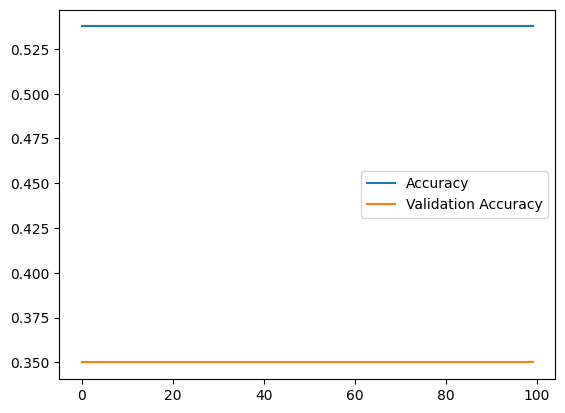

In [ ]:
print(history.history.keys())

plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print_model_layers(model)

For layer 0:
Weights = [[0.05664388 0.05664388 0.05664388 0.05664388 0.05664388 0.05664388
  0.05664388 0.05664388 0.05664388 0.05664388 0.05664388 0.05664388
  0.05664388 0.05664388 0.05664388 0.05664388 0.05664388 0.05664388
  0.05664388 0.05664388 0.05664388 0.05664388 0.05664388 0.05664388
  0.05664388 0.05664388 0.05664388 0.05664388 0.05664388 0.05664388
  0.05664388 0.05664388]
 [0.09396121 0.09396121 0.09396121 0.09396121 0.09396121 0.09396121
  0.09396121 0.09396121 0.09396121 0.09396121 0.09396121 0.09396121
  0.09396121 0.09396121 0.09396121 0.09396121 0.09396121 0.09396121
  0.09396121 0.09396121 0.09396121 0.09396121 0.09396121 0.09396121
  0.09396121 0.09396121 0.09396121 0.09396121 0.09396121 0.09396121
  0.09396121 0.09396121]]

Biases = [0.02740828 0.02740828 0.02740828 0.02740828 0.02740828 0.02740828
 0.02740828 0.02740828 0.02740828 0.02740828 0.02740828 0.02740828
 0.02740828 0.02740828 0.02740828 0.02740828 0.02740828 0.02740828
 0.02740828 0.02740828 0.02740828 0

# Variation of Activations per layer, per epoch

In [ ]:
model = Sequential()

model.add(Dense(units=32, activation='relu', input_shape=(2,)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

activation_callback = ActivationTracker(model, X)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y_tensor, batch_size=32, validation_split=0.2, epochs=100, callbacks=[activation_callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                96        
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
3/3 [==============================] - 1s 267ms/step - loss: 0.6938 - accuracy: 0.4875 - val_loss: 0.6888 - val_accuracy: 0.5500
Epoch 2/100
3/3 [==============================] - 0s 63ms/step - loss: 0.6925 - accuracy: 0.4875 - val_loss: 0.6905 - val_accuracy: 0.5500
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


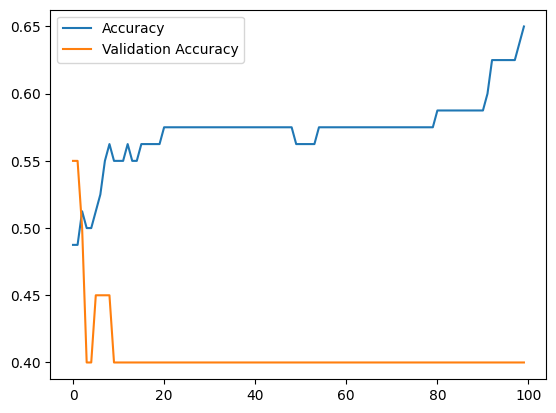

In [ ]:
print(history.history.keys())

plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print(len(activation_callback.activations_arr))

300


100 epochs, 3 layers ⇒ 300

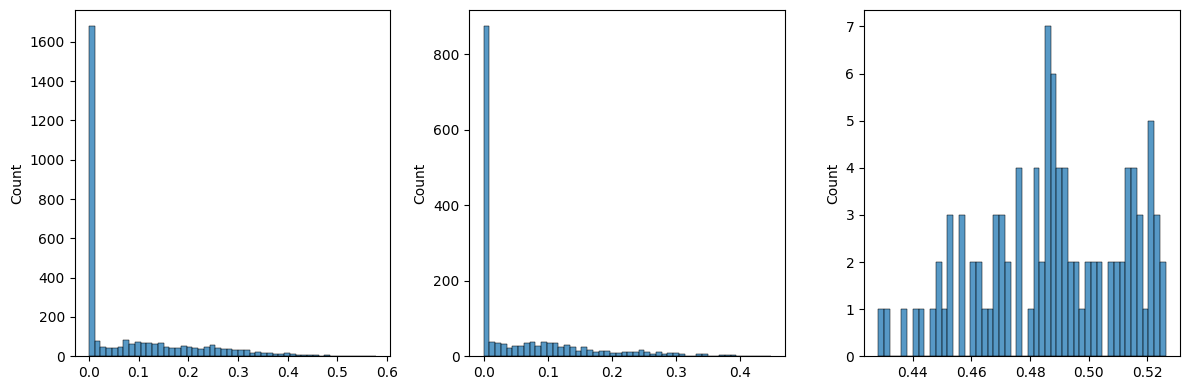

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sb.histplot(activation_callback.activations_arr[0].flatten(), bins=50, ax=ax[0])
sb.histplot(activation_callback.activations_arr[1].flatten(), bins=50, ax=ax[1])
sb.histplot(activation_callback.activations_arr[2].flatten(), bins=50, ax=ax[2])

plt.tight_layout()
plt.show()

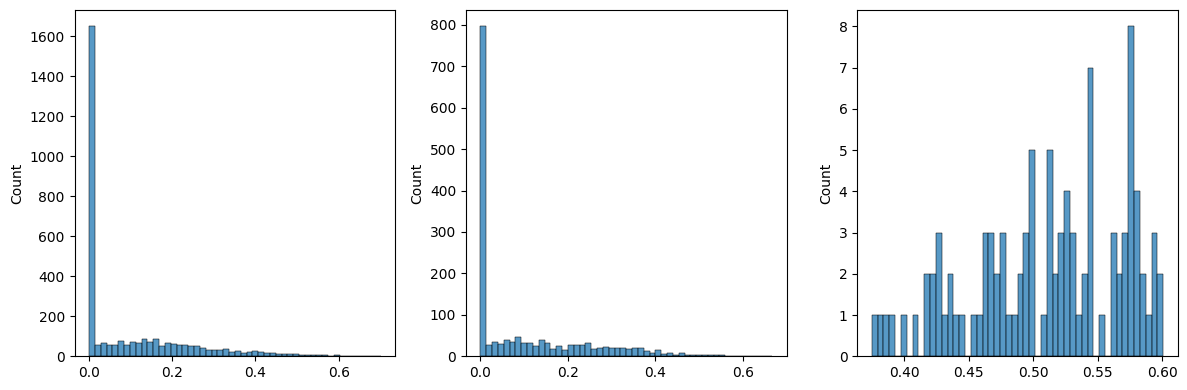

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sb.histplot(activation_callback.activations_arr[99*3].flatten(), bins=50, ax=ax[0])
sb.histplot(activation_callback.activations_arr[99*3+1].flatten(), bins=50, ax=ax[1])
sb.histplot(activation_callback.activations_arr[99*3+2].flatten(), bins=50, ax=ax[2])

plt.tight_layout()
plt.show()